In [1]:
!pip install --quiet pennylane

In [2]:
import numpy as np
import pandas as pd
import pennylane as qml
from sklearn.preprocessing import LabelEncoder
from scipy.stats import chi2_contingency
from numpy import pi
import matplotlib.pyplot as plt

/opt/conda/lib/python3.10/site-packages/pennylane/capture/capture_operators.py:33: RuntimeWarning: PennyLane is not yet compatible with JAX versions > 0.4.28. You have version 0.4.31 installed. Please downgrade JAX to <=0.4.28 to avoid runtime errors.
  warnings.warn(


In [3]:
df=pd.read_csv("/kaggle/input/iris/Iris.csv")
df.drop("Id",axis=1,inplace=True)
df.head()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [4]:
label_encoder=LabelEncoder()
df["Species"]=label_encoder.fit_transform(df["Species"])
df.head()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [5]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(df.drop("Species",axis=1),df["Species"],test_size=0.2,random_state=42)

In [6]:
from sklearn.preprocessing import MinMaxScaler
mms=MinMaxScaler()
X_train=mms.fit_transform(X_train)
X_test=mms.fit_transform(X_test)

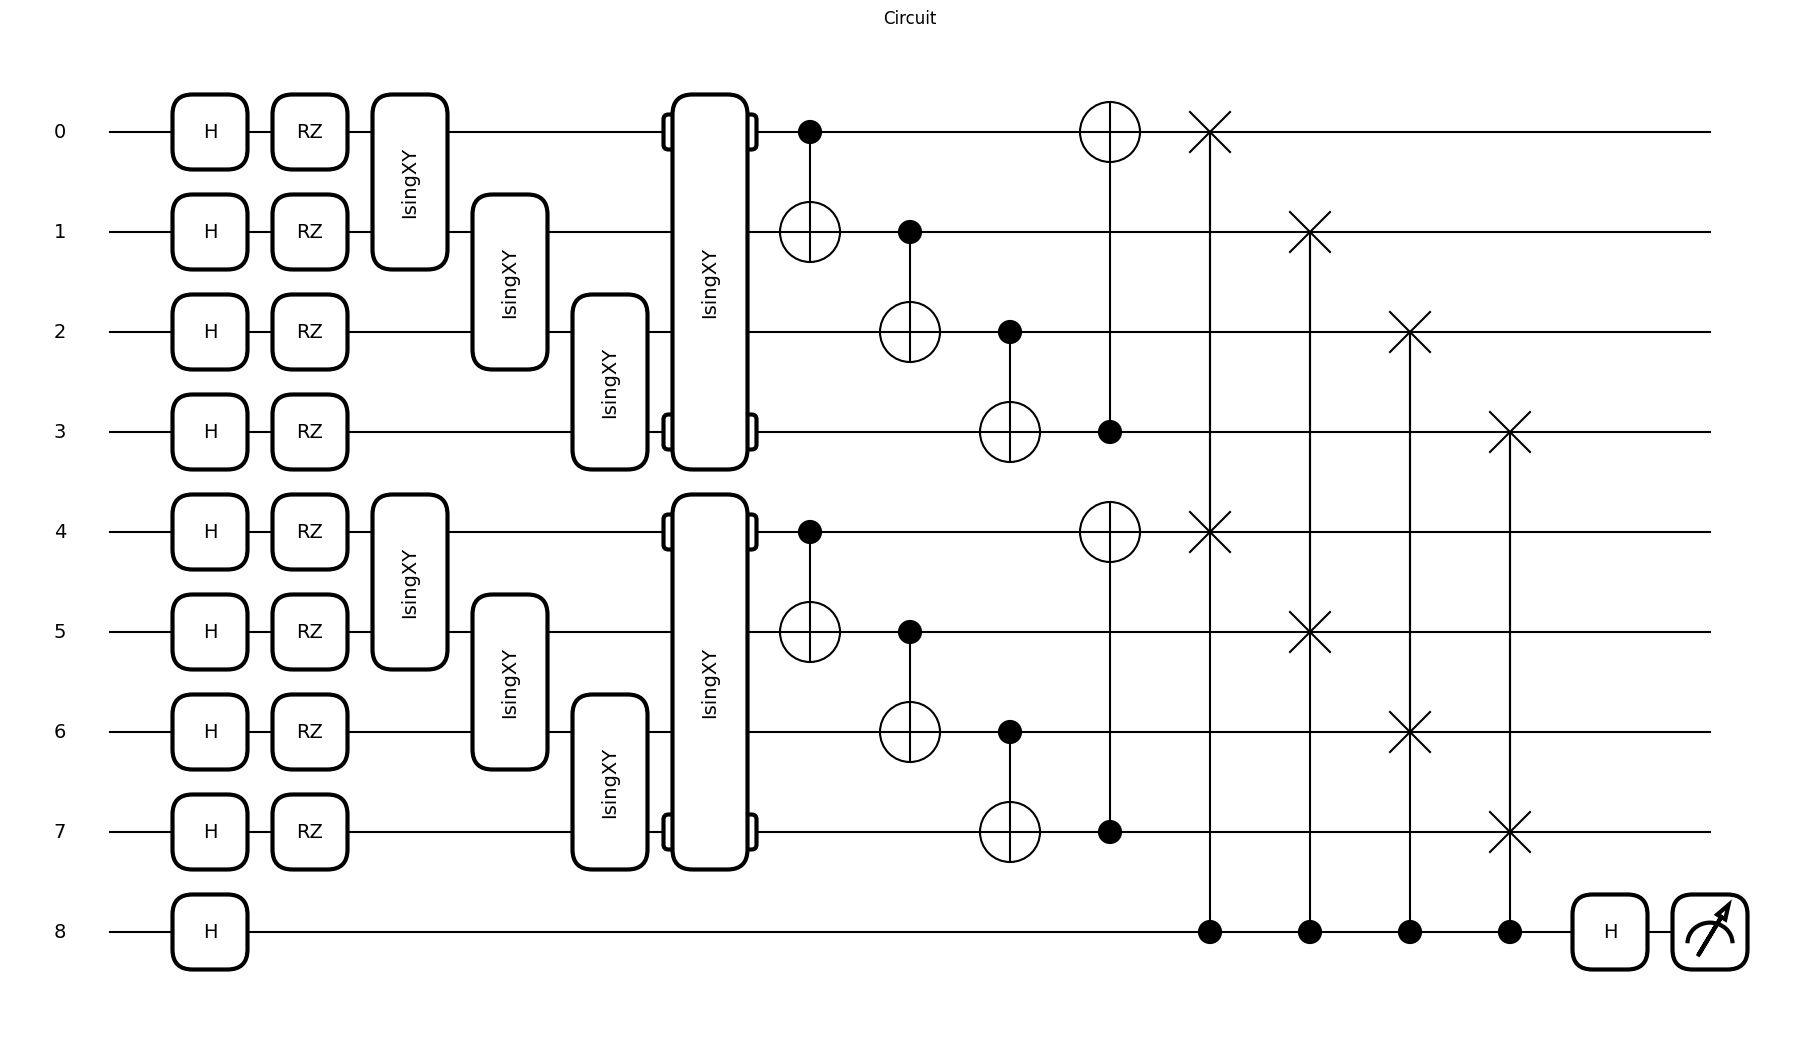

In [7]:
dev=qml.device("lightning.qubit",wires=9)

@qml.qnode(dev)
def circuit(x_train,x_test):
    for i in range(len(x_train)*2):
        qml.Hadamard(wires=i)
    
    qml.Hadamard(wires=(len(x_train)*2))
    
    #qml.Barrier(wires=(len(x_train)*2)+1)
        
    for i in range(len(x_train)):
            qml.RZ(x_train[i],wires=i)
            
    
    for i in range(len(x_test)):
            qml.RZ(x_test[i],wires=i+len(x_train))
            
    for i in range(len(x_train)):        
            if i==len(x_train)-1:
                qml.IsingXY(pi/3,wires=[i,i-len(x_train)+1])
            else:
                qml.IsingXY(pi/3,wires=[i,i+1])
            
    for i in range(len(x_test)): 
            
            if i==len(x_test)-1:
                qml.IsingXY(pi/3,wires=[i+len(x_train),i+1])
            else:
                qml.IsingXY(pi/3,wires=[i+len(x_train),i+1+len(x_train)])
                
    for i in range(len(x_train)):        
            if i==len(x_train)-1:
                qml.CNOT(wires=[i,i-len(x_train)+1])
            else:
                qml.CNOT(wires=[i,i+1])
    for i in range(len(x_test)): 
            
            if i==len(x_test)-1:
                qml.CNOT(wires=[i+len(x_train),i+1])
            else:
                qml.CNOT(wires=[i+len(x_train),i+1+len(x_train)])
                
    for i in range(len(x_train)):
        qml.CSWAP(wires=[(len(x_train)*2),i,i+len(x_train)])
        
    
    qml.Hadamard(wires=(len(x_train)*2))
        
    return qml.expval(qml.PauliZ(8))
    #return qml.probs(wires=(len(x_train)*2))

fig, ax = qml.draw_mpl(circuit)(X_train[0],X_test[0])
ax.set_title("Circuit")
plt.show()

In [8]:
result=circuit(X_train[0],X_test[1])
print(result)

0.9584963841863927


In [9]:
y_train=y_train.to_numpy()
y_test=y_test.to_numpy()

In [10]:
y_train[0]

0

In [11]:
y_test[0]

1

In [12]:
prediction=[]
for j in range(len(X_test)):
    a=[]
    for i in range(len(X_train)):
        if circuit(X_train[i],X_test[j])>0.96:
            a.append(y_train[i])
        
    count_0=a.count(0)
    count_1=a.count(1)
    count_2=a.count(2)
    if count_0>count_1 and count_0>count_2:
        prediction.append(0)
    elif count_1>count_0 and count_1>count_2:
        prediction.append(1)
        
    else:
        prediction.append(2)
        
  

In [13]:
#prediction
prediction_n=np.array(prediction)

In [14]:
from sklearn.metrics import accuracy_score

accuracy=accuracy_score(y_test,prediction_n)
print(accuracy)

1.0


In [16]:
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
print("\nClassification Report:")
print(classification_report(y_test, prediction_n))


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00        11

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



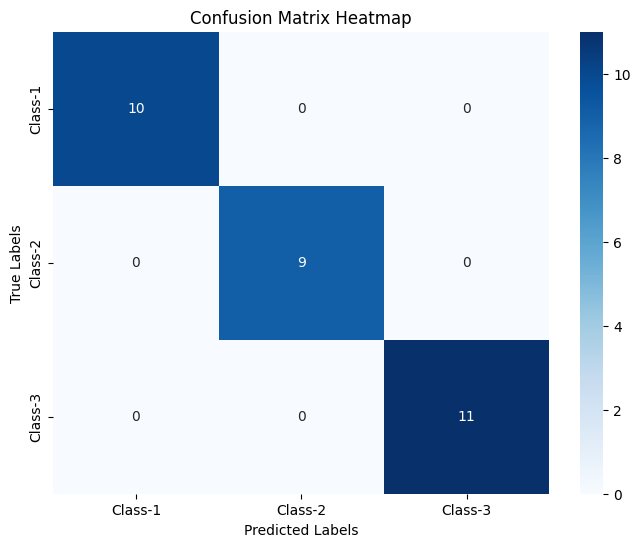

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute confusion matrix
cm = confusion_matrix(y_test, prediction_n)
class_names = ['Class-1', 'Class-2','Class-3'] 

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Heatmap')
plt.show()

In [18]:
from sklearn.neighbors import KNeighborsRegressor


# Create and train the KNN regressor
knn_regressor = KNeighborsRegressor(n_neighbors=5)
knn_regressor.fit(X_train, y_train)

# Make predictions on the test data
y_pred = knn_regressor.predict(X_test)

# Convert probabilities to three classes: 0, 1, or 2 predictions
threshold_0 = 0.33
threshold_1 = 0.67

y_pred_classes = []
for pred in y_pred:
    if pred < 0.5:
        y_pred_classes.append(0)
    elif pred >0.5 and pred < 1.5:
        y_pred_classes.append(1)
    else:
        y_pred_classes.append(2)




In [19]:
accuracy=accuracy_score(y_test,y_pred_classes)
print(accuracy)

1.0
